# 汇总

## 遍历每个文件名

In [12]:
import os
import pandas as pd
os.chdir('E:\\All Files\\temp\\数据0\\raw_data')
files = os.listdir()
from functools import reduce
files

['20210125b.log',
 '20210125济-章丘.log',
 '20210411-3.log',
 '20210411_1.log',
 '20210411_2.log']

In [15]:
def data_format(result,file):   # 第一个参数是处理值，第二个是新的输入
    rawdata = []
    data = []
    with open(file,"r") as f:
        rawdata = f.readlines()
    for i in rawdata[16:]:
        data.append([i.split()[1],i.split()[4],i.split()[-2]])
    grouped_data=[]
    index = 0
    temp_list=[]
    for i in data:
        if index%3==0 and index!=0:
            grouped_data.append(temp_list)
            temp_list=[]
        temp_list.append(i)
        index=index+1
    result_data = []
    for i in grouped_data:
        result_data.append([i[0][0][0:-2],i[0][2].split("=")[1],i[1][2].split("=")[1],i[2][2].split("=")[1]])
    result = result + result_data
    return result
result = pd.DataFrame(reduce(data_format,files,[]),columns=['time','制动','油门','转向'])
result.to_excel('E:\\All Files\\temp\\数据0\\raw_data\\alldata.xlsx')

## 改进
+ 滤波
+ 加入变化率
+ 去除负值和三项均为0的值
+ 改为每秒变化（50个）

In [3]:
import pandas as pd
driving_data = pd.read_excel("E:\\All Files\\temp\\数据0\\raw_data\\alldata.xlsx")

+ 只过滤
+ 只采用采用每秒变化

In [2]:
from scipy import signal
b, a = signal.butter(8, 0.04, 'lowpass')   #配置滤波器 8 表示滤波器的阶数
driving_data['油门'] = signal.filtfilt(b, a, driving_data['油门'])  #data为要过滤的信号
driving_data['转向'] = signal.filtfilt(b, a, driving_data['转向'])  #data为要过滤的信号
driving_data['制动'] = signal.filtfilt(b, a, driving_data['制动'])  #data为要过滤的信号
driving_data.to_excel("E:\\All Files\\temp\\数据0\\raw_data\\alldata_filtered.xlsx")

KeyboardInterrupt: 

去除三项均为0的行

In [6]:
b= pd.DataFrame([[1,2,3],[4,5,6]])
b

,0,1,2
0,1,2,3
1,4,5,6


滤波的处理方式

In [ ]:
for index,row in driving_data.iterrows():
    changed = 0
    if row['油门'] < 0:
        driving_data['油门'][index]==0
        changed+=1
    if row['制动'] < 0:
        driving_data['制动'][index]==0
        changed+=1
    if row['油门'] == 0 and row['转向'] and ['制动'] ==0:
        driving_data.drop(index,axis=0,inplace=True)   # axis 1为列，0为行，inplace表示对原dataframe修改
        continue
    if changed == 2:
        driving_data.drop(index,axis=0,inplace=True)   # axis 1为列，0为行，inplace表示对原dataframe修改

不滤波的处理方式

In [4]:
for index,row in driving_data.iterrows():
    if row['油门'] == 0 and row['转向'] and ['制动'] ==0:
        driving_data.drop(index,axis=0,inplace=True)   # axis 1为列，0为行，inplace表示对原dataframe修改

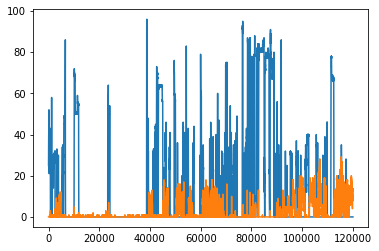

In [6]:
from matplotlib import pyplot as plt
import numpy as np
plt.plot(driving_data['制动'][0:120000])
plt.plot(driving_data['油门'][0:120000])

找出每50个的最大值和最小值，填入两者之和的一半

In [25]:
count_num = 0
row_num = 0
improved_data = pd.DataFrame(columns = ['油门','转向','制动','油门变化','转向变化','制动变化'])
temp_list = [[],[],[]]
for index,row in driving_data.iterrows():
    count_num += 1
    # 放入临时列表
    temp_list[0].append(row['油门'])
    temp_list[1].append(row['转向'])
    temp_list[2].append(row['制动'])
    # 检查是否第50个
    if count_num == 50:
        # 清零
        count_num = 0
        # 添加数据
        improved_data.loc[row_num]=[
#                                     (min(temp_list[0])+max(temp_list[0]))/2,
#                                     (min(temp_list[1])+max(temp_list[1]))/2,
#                                     (min(temp_list[2])+max(temp_list[2]))/2,
#                                     (max(temp_list[0])-min(temp_list[0])),
#                                     (max(temp_list[1])-min(temp_list[1])),
#                                     (max(temp_list[2])-min(temp_list[2])),
            # 取第一个值
                                    temp_list[0][0],
                                    temp_list[1][0],
                                    temp_list[2][0],
                                    (max(temp_list[0])-min(temp_list[0])),
                                    (max(temp_list[1])-min(temp_list[1])),
                                    (max(temp_list[2])-min(temp_list[2])),
                                   ]
        # 最后清空临时列表并添加行数
        temp_list = [[],[],[]]
        row_num += 1


In [27]:
improved_data.to_excel("E:\\All Files\\temp\\数据0\\raw_data\\improved_data.xlsx")

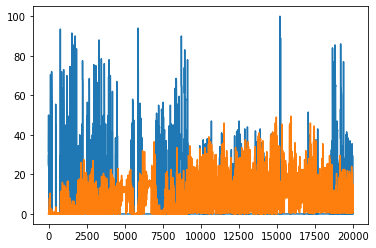

In [22]:
from matplotlib import pyplot as plt
import numpy as np
plt.plot(improved_data['制动'])
plt.plot(improved_data['油门'])

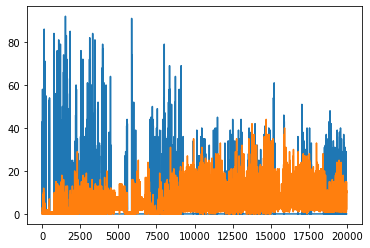

In [23]:
from matplotlib import pyplot as plt
import numpy as np
plt.plot(improved_data['制动变化'])
plt.plot(improved_data['油门变化'])

# 处理元数据

根据每行分组并只留下时间和角度及其种类

In [13]:
rawdata = []
data = []
for line in open("C:/Users/Administrator/Desktop/毕业论文/转向油门制动数据/20210408.log","r"): #设置文件对象并读取每一行文件
    rawdata.append(line)               #将每一行文件加入到list中
rawdata[0:5]

['         2 19:17:45.781.7   1  Rx    Steering             Steering_angle_current=46 degree\n',
 '         3 19:17:45.782.0   1  Rx    Break                Break_peadl_Displacement1=41 % Break_pedal_Displacement=42 %\n',
 '         4 19:17:45.782.3   1  Rx    Throttle             Throttle_opening=0 %\n',
 '         7 19:17:45.801.7   1  Rx    Steering             Steering_angle_current=46 degree\n',
 '         8 19:17:45.802.0   1  Rx    Break                Break_peadl_Displacement1=40 % Break_pedal_Displacement=41 %\n']

In [14]:
data = []
for i in rawdata:
    data.append([i.split()[1],i.split()[4],i.split()[-2]])

根据第一列的时间分组：
1. 每三个分一组
2. 以每组的第一个作为时间

In [15]:
data[0]

['19:17:45.781.7', 'Steering', 'Steering_angle_current=46']

每三个分一组

In [16]:
grouped_data=[]
index = 0
temp_list=[]
for i in data:
    if index%3==0 and index!=0:
        if index <20:
            print("index"+str(index)+"被执行了")
        grouped_data.append(temp_list)
        temp_list=[]
    temp_list.append(i)
    index=index+1
    if index < 20:
        print(temp_list)

[['19:17:45.781.7', 'Steering', 'Steering_angle_current=46']]
[['19:17:45.781.7', 'Steering', 'Steering_angle_current=46'], ['19:17:45.782.0', 'Break', 'Break_pedal_Displacement=42']]
[['19:17:45.781.7', 'Steering', 'Steering_angle_current=46'], ['19:17:45.782.0', 'Break', 'Break_pedal_Displacement=42'], ['19:17:45.782.3', 'Throttle', 'Throttle_opening=0']]
index3被执行了
[['19:17:45.801.7', 'Steering', 'Steering_angle_current=46']]
[['19:17:45.801.7', 'Steering', 'Steering_angle_current=46'], ['19:17:45.802.0', 'Break', 'Break_pedal_Displacement=41']]
[['19:17:45.801.7', 'Steering', 'Steering_angle_current=46'], ['19:17:45.802.0', 'Break', 'Break_pedal_Displacement=41'], ['19:17:45.802.3', 'Throttle', 'Throttle_opening=0']]
index6被执行了
[['19:17:45.821.7', 'Steering', 'Steering_angle_current=46']]
[['19:17:45.821.7', 'Steering', 'Steering_angle_current=46'], ['19:17:45.822.0', 'Break', 'Break_pedal_Displacement=41']]
[['19:17:45.821.7', 'Steering', 'Steering_angle_current=46'], ['19:17:45.8

In [17]:
grouped_data[0][2][2].split("=")[1]

'0'

将三个一组的进行处理

In [18]:
result_data = []
for i in grouped_data:
    result_data.append([i[0][0][0:-2],i[0][2].split("=")[1],i[1][2].split("=")[1],i[2][2].split("=")[1]])

In [19]:
result_data[0:10]

[['19:17:45.781', '46', '42', '0'],
 ['19:17:45.801', '46', '41', '0'],
 ['19:17:45.821', '46', '41', '0'],
 ['19:17:45.841', '46', '40', '0'],
 ['19:17:45.861', '46', '40', '0'],
 ['19:17:45.881', '46', '40', '0'],
 ['19:17:45.901', '46', '40', '0'],
 ['19:17:45.921', '46', '40', '0'],
 ['19:17:45.941', '46', '40', '0'],
 ['19:17:45.961', '46', '39', '1']]

写入excel

In [20]:
import pandas as pd

result = pd.DataFrame(result_data,columns=["时间","Steering","Break","Throttle"])
result

,时间,Steering,Break,Throttle
0,19:17:45.781,46,42,0
1,19:17:45.801,46,41,0
2,19:17:45.821,46,41,0
3,19:17:45.841,46,40,0
4,19:17:45.861,46,40,0
...,...,...,...,...
231936,19:42:42.053,-30,0,0
231937,19:42:42.073,-30,0,0
231938,19:42:42.093,-30,0,0
231939,19:42:42.113,-30,0,0


In [21]:
result.to_excel("E://驾驶意图//20210408.xlsx")

# 数据处理

## excel表合并

In [46]:
import pandas as pd
data_1 = pd.read_excel("E://驾驶意图/data_1.xlsx")
data_2 = pd.read_excel("E://驾驶意图/data_2.xlsx")
data_3 = pd.read_excel("E://驾驶意图/data_3.xlsx")

In [47]:
result = pd.concat([data_1,data_2,data_3])

In [48]:
result.to_excel("E://驾驶意图//data.xlsx")

## 初步处理

In [1]:
driving_data = read.csv2("E://20210125.CSV",sep = ",")
head(driving_data)

NameError: name 'read' is not defined

相关系数

In [3]:
cor(driving_data$Steering,driving_data$Break)
cor(driving_data$Steering,driving_data$Throttle)
cor(driving_data$Break,driving_data$Throttle)

[1] -0.01194208

[1] 0.1141515

[1] -0.4407044

In [4]:
cor.test(driving_data$Steering,driving_data$Break)


	Pearson's product-moment correlation

data:  driving_data$Steering and driving_data$Break
t = -6.8144, df = 325560, p-value = 9.483e-12
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.015376489 -0.008507393
sample estimates:
        cor 
-0.01194208 


时间图

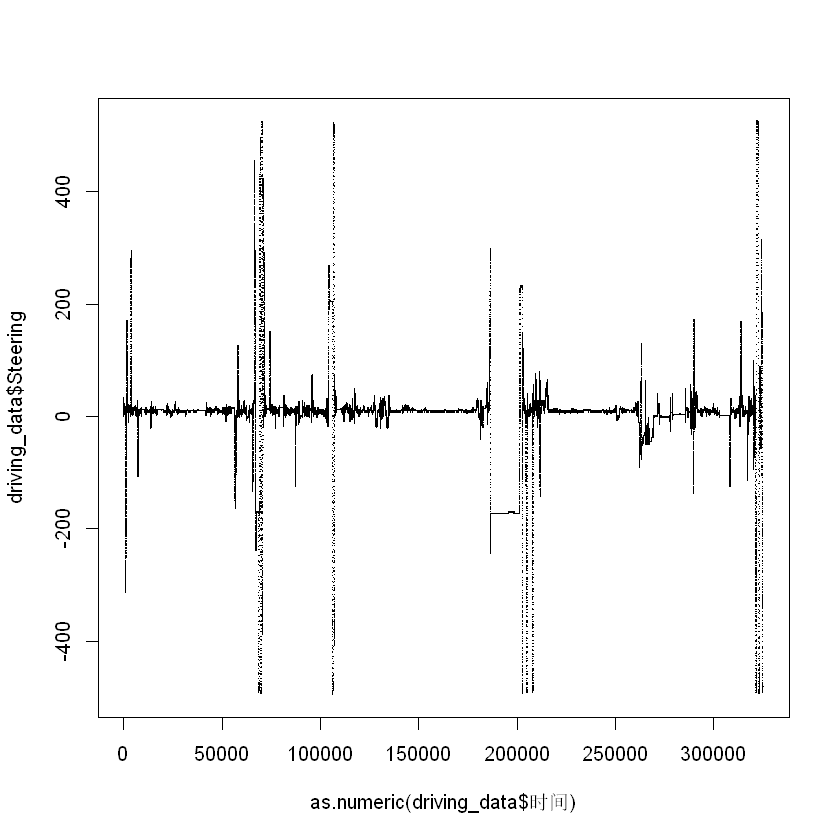

In [23]:
plot(as.numeric(driving_data$时间),driving_data$Steering,pch = ".")

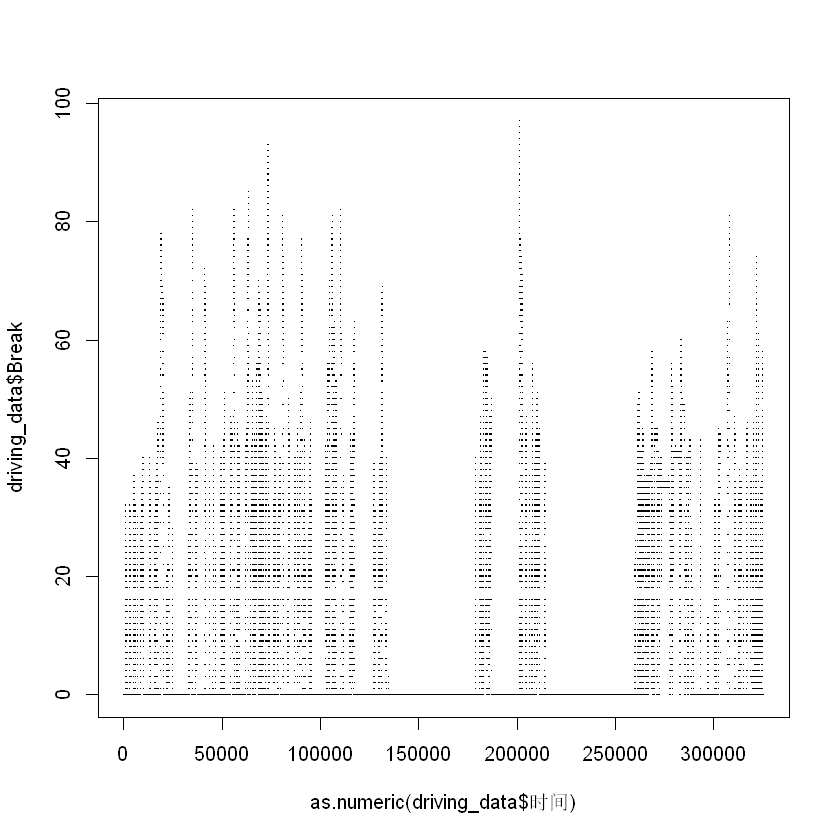

In [24]:
plot(as.numeric(driving_data$时间),driving_data$Break,pch = ".")

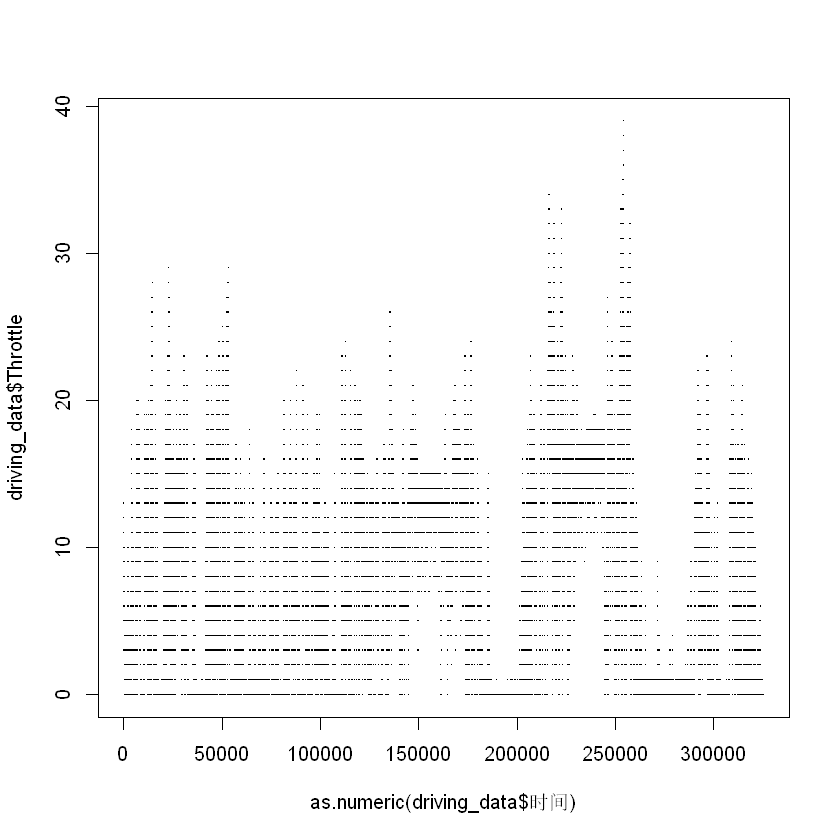

In [31]:
plot(as.numeric(driving_data$时间),driving_data$Throttle,pch = ".")

转向柱状图

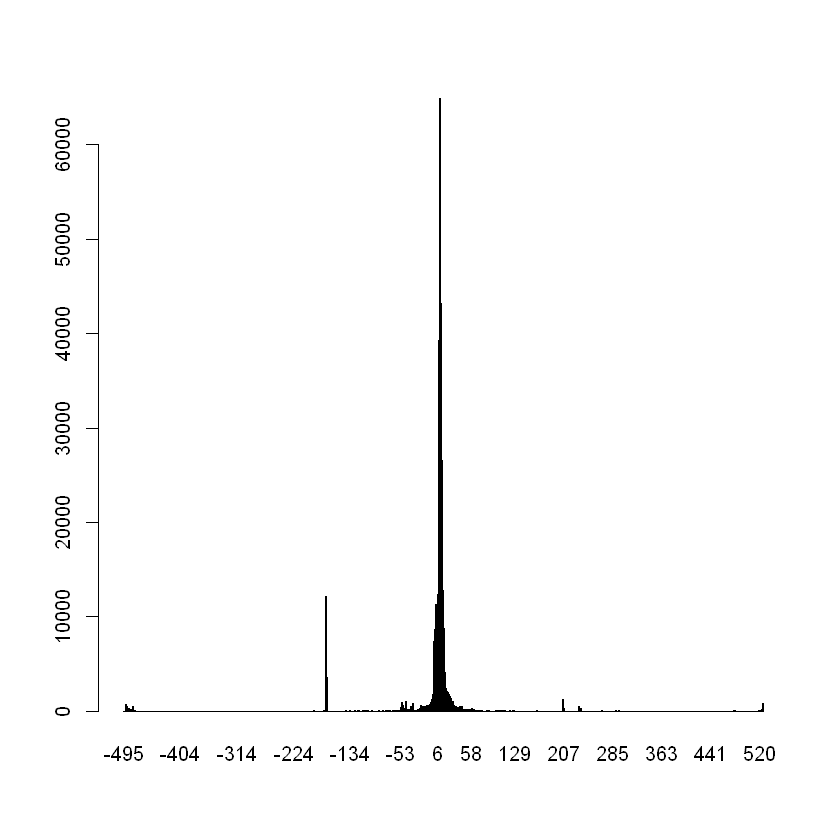

In [8]:
barplot(table(driving_data$Steering))

制动踏板柱状图

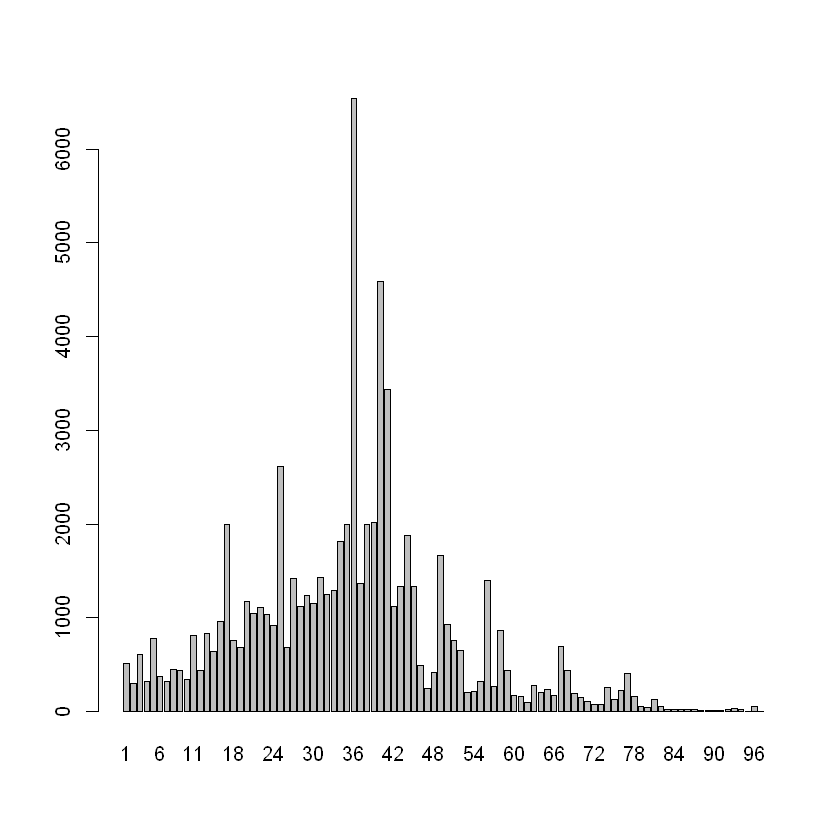

In [13]:
barplot(table(driving_data$Break[-driving_data$Break!=0]))

加速频率图

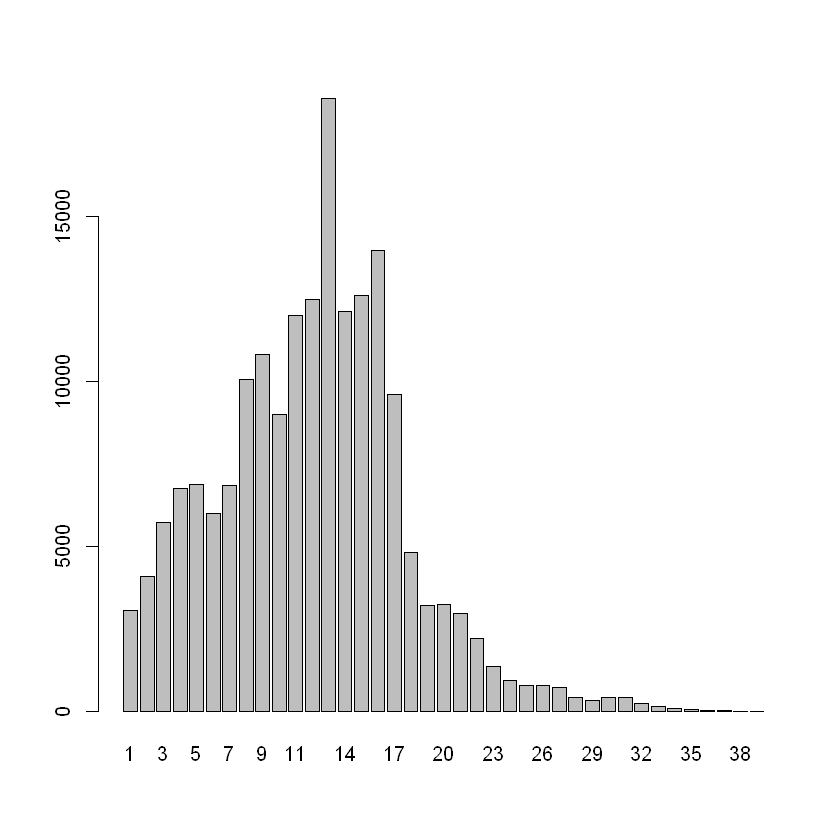

In [15]:
barplot(table(driving_data$Throttle[-driving_data$Throttle!=0]))

## 滤波

In [10]:
from scipy import signal
import math
from matplotlib import pyplot as plt

In [18]:
import pandas as pd
driving_data = pd.read_excel("E://20210125.xlsx")

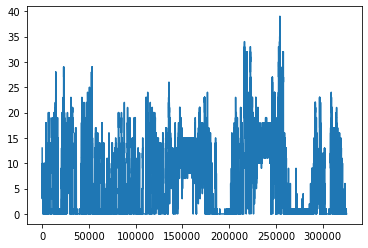

In [20]:
plt.plot(driving_data["Throttle"])

Wn：归一化截止频率。计算公式Wn=2*截止频率/采样频率。（注意：根据采样定理，采样频率要大于两倍的信号本身最大的频率，才能还原信号。截止频率一定小于信号本身最大的频率，所以Wn一定在0和1之间）。当构造带通滤波器或者带阻滤波器时，Wn为长度为2的列表。
+ 截止频率是需要的频率，采样频率是采集的频率

In [28]:
b, a = signal.butter(8, 0.04, 'lowpass')   #配置滤波器 8 表示滤波器的阶数
filtedData = signal.filtfilt(b, a, driving_data["Throttle"])  #data为要过滤的信号

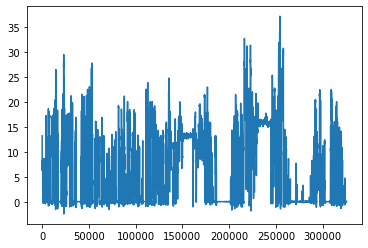

In [29]:
plt.plot(filtedData)

In [37]:
lvbo = pd.DataFrame()
lvbo["data"] = driving_data["Throttle"]
lvbo["filted_data"] = filtedData
lvbo["index"] = range(len(filtedData))

In [38]:
pd.DataFrame(lvbo).to_csv("E://滤波.CSV")

In [33]:
index = 0
for i in filtedData:
    if i < 0:
        index
    index = index + 1

array([1.32140697e+01, 1.30581488e+01, 1.28997851e+01, ...,
       7.00906324e-06, 7.14531126e-06, 7.25725904e-06])

## 处理成论文的格式

In [1]:
import pandas as pd
driving_data = pd.read_excel("E:\\All Files\\temp\\数据0\\raw_data\\alldata.xlsx")

In [1]:
import pandas as pd
driving_data = pd.read_excel("E://20210125.xlsx")

In [3]:
# driving_data.to_csv("E://驾驶意图//data.CSV")

In [17]:
driving_data[0:5]

,Unnamed: 0,time,制动,油门,转向
0,0,16:10:23.501,25,0,-21
1,1,16:10:23.521,26,0,-21
2,2,16:10:23.541,28,0,-20
3,3,16:10:23.561,28,0,-20
4,4,16:10:23.581,29,0,-20


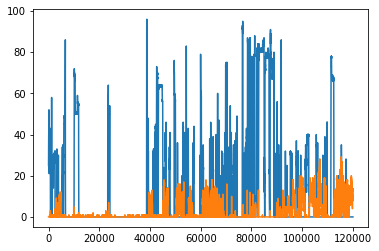

In [27]:
from matplotlib import pyplot as plt
import numpy as np
plt.plot(driving_data['制动'][0:120000])
plt.plot(driving_data['油门'][0:120000])

### 加速数据的处理

1. 分出每一次的加速
2. 计算出每一次加速时，加速踏板的最大开度
3. 放入一个数组

In [28]:
acc_raw_data = driving_data["油门"]
acc_raw_data[0:5]

0    0
1    0
2    0
3    0
4    0
Name: 油门, dtype: int64

In [40]:
acc_raw_data = filtedData

In [43]:
num = len(acc_raw_data)
num

325562

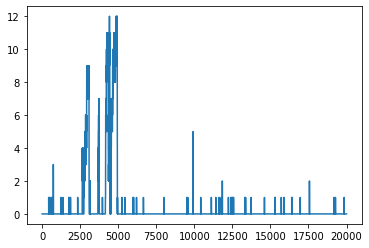

In [30]:
from matplotlib import pyplot as plt
import numpy as np
plt.plot(np.arange(20000),acc_raw_data[0:20000])

在连续多个零的时候，只加入一个最大值

In [32]:
acc_data = []
zero_index = 0
not_zero_list = []
index = 0
for i in acc_raw_data:
    if i <=0.1:
        if index ==0 and not_zero_list!=[]:
            acc_data.append(max(not_zero_list))
        not_zero_list = []
        index = 1
        continue
    not_zero_list.append(i)
    index = 0

ValueError: max() arg is an empty sequence

In [49]:
max(acc_data),len(acc_data)

(37.2094164029836, 556)

In [50]:
acc_data[1]

0.15356495560391564

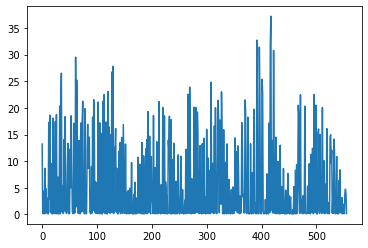

In [51]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(len(acc_data)),acc_data)

In [53]:
pd.DataFrame(acc_data).to_csv("E://加速.CSV")

### 制动数据处理

In [15]:
acc_raw_data = driving_data["Break"]
acc_raw_data[0:5]

0    0
1    0
2    0
3    0
4    0
Name: Break, dtype: int64

在连续多个零的时候，只加入一个最大值

In [16]:
acc_data = []
zero_index = 0
not_zero_list = []
index = 1
for i in acc_raw_data:
    if i == 0 or i == 1:
        if index ==0:
            acc_data.append(max(not_zero_list))
        not_zero_list = []
        index = 1
        continue
    not_zero_list.append(i)
    index = 0

In [17]:
max(acc_data),len(acc_data)

(100, 277)

In [13]:
acc_data

[32,
 25,
 32,
 31,
 37,
 32,
 11,
 30,
 40,
 40,
 36,
 30,
 22,
 39,
 46,
 78,
 20,
 22,
 35,
 28,
 27,
 51,
 82,
 27,
 1,
 39,
 72,
 36,
 1,
 3,
 42,
 3,
 25,
 40,
 33,
 34,
 36,
 51,
 47,
 82,
 1,
 46,
 42,
 29,
 77,
 85,
 53,
 44,
 70,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 51,
 1,
 1,
 68,
 36,
 50,
 51,
 50,
 40,
 14,
 47,
 93,
 31,
 33,
 45,
 28,
 40,
 81,
 50,
 40,
 45,
 51,
 77,
 43,
 28,
 46,
 33,
 33,
 42,
 26,
 56,
 37,
 70,
 8,
 81,
 51,
 63,
 53,
 82,
 37,
 44,
 43,
 63,
 39,
 31,
 40,
 69,
 40,
 3,
 40,
 47,
 40,
 58,
 34,
 50,
 97,
 1,
 77,
 71,
 47,
 23,
 37,
 56,
 43,
 51,
 39,
 26,
 49,
 51,
 30,
 28,
 41,
 45,
 37,
 37,
 37,
 1,
 1,
 58,
 31,
 45,
 41,
 40,
 56,
 42,
 60,
 40,
 43,
 28,
 9,
 43,
 13,
 33,
 20,
 45,
 1,
 44,
 63,
 81,
 47,
 34,
 38,
 36,
 20,
 46,
 36,
 46,
 1,
 15,
 40,
 25,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 74,
 14,
 61,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 19,
 36,
 58]

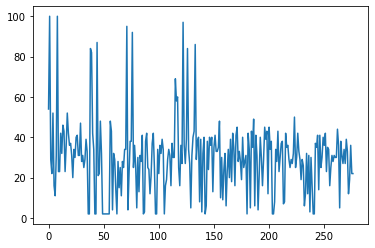

In [18]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(277),acc_data)

In [9]:
pd.DataFrame(acc_data).to_csv("E://驾驶意图//制动.CSV")

### 角速度处理

In [3]:
acc_raw_data = driving_data["Steering"]
acc_raw_data[0:5]

0    33
1    33
2    33
3    31
4    31
Name: Steering, dtype: int64

在连续多个零的时候，只加入一个最大值

In [4]:
acc_data = []
zero_index = 0
not_zero_list = []
index = 1
for i in acc_raw_data:
    if i == 0 or i == 1:
        if index ==0:
            # 判断出左右转
            # 或者另一种方法：取平均值
            if sum(not_zero_list)>0:
                acc_data.append(max(not_zero_list))
            if sum(not_zero_list)<0:
                acc_data.append(min(not_zero_list))
        not_zero_list = []
        index = 1
        continue
    not_zero_list.append(i)
    index = 0

In [5]:
max(acc_data),len(acc_data)

(525, 271)

In [13]:
acc_data

[32,
 25,
 32,
 31,
 37,
 32,
 11,
 30,
 40,
 40,
 36,
 30,
 22,
 39,
 46,
 78,
 20,
 22,
 35,
 28,
 27,
 51,
 82,
 27,
 1,
 39,
 72,
 36,
 1,
 3,
 42,
 3,
 25,
 40,
 33,
 34,
 36,
 51,
 47,
 82,
 1,
 46,
 42,
 29,
 77,
 85,
 53,
 44,
 70,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 51,
 1,
 1,
 68,
 36,
 50,
 51,
 50,
 40,
 14,
 47,
 93,
 31,
 33,
 45,
 28,
 40,
 81,
 50,
 40,
 45,
 51,
 77,
 43,
 28,
 46,
 33,
 33,
 42,
 26,
 56,
 37,
 70,
 8,
 81,
 51,
 63,
 53,
 82,
 37,
 44,
 43,
 63,
 39,
 31,
 40,
 69,
 40,
 3,
 40,
 47,
 40,
 58,
 34,
 50,
 97,
 1,
 77,
 71,
 47,
 23,
 37,
 56,
 43,
 51,
 39,
 26,
 49,
 51,
 30,
 28,
 41,
 45,
 37,
 37,
 37,
 1,
 1,
 58,
 31,
 45,
 41,
 40,
 56,
 42,
 60,
 40,
 43,
 28,
 9,
 43,
 13,
 33,
 20,
 45,
 1,
 44,
 63,
 81,
 47,
 34,
 38,
 36,
 20,
 46,
 36,
 46,
 1,
 15,
 40,
 25,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 74,
 14,
 61,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 19,
 36,
 58]

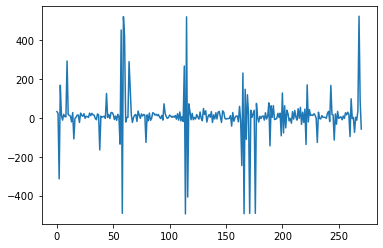

In [6]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(271),acc_data)

In [7]:
pd.DataFrame(acc_data).to_csv("E://转角.CSV")

### 角速度变化率处理

$\frac{制动踏板开度*2}{时间}$

In [8]:
acc_grad_data = []
zero_index = 0
not_zero_list = []
time = 0
for i in acc_raw_data:
    time = time + 0.02
    if i == 0 or i == 1:
        if index ==0:
            if sum(not_zero_list)>0:
                acc_grad_data.append(max(not_zero_list)*2/(time))
            if sum(not_zero_list)<0:
                acc_grad_data.append(min(not_zero_list)*2/(time))
        not_zero_list = []
        index = 1
        time = 0
        continue
    not_zero_list.append(i)
    index = 0

In [9]:
pd.DataFrame(acc_grad_data).to_csv("E://转角变化率.CSV")

In [10]:
len(acc_grad_data),max(acc_grad_data)

(271, 205.3398058252427)

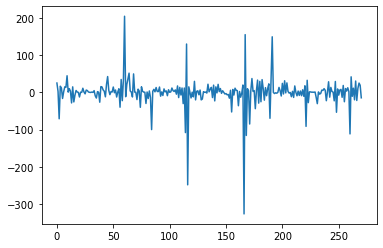

In [11]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(271),acc_grad_data)

### 制动变化率数据处理

$\frac{制动踏板开度*2}{时间}$

In [22]:
acc_grad_data = []
zero_index = 0
not_zero_list = []
time = 0
for i in acc_raw_data:
    time = time + 0.02
    if i == 0 or i == 1:
        if index ==0:
            acc_grad_data.append((max(not_zero_list)*2)/(time))
        not_zero_list = []
        index = 1
        time = 0
        continue
    not_zero_list.append(i)
    index = 0

In [11]:
pd.DataFrame(acc_grad_data).to_csv("E://驾驶意图//制动变化率.CSV")

In [23]:
len(acc_grad_data),max(acc_grad_data)

(277, 100.0)

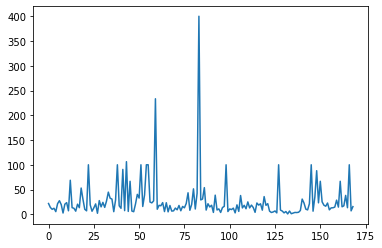

In [25]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(169),acc_grad_data)

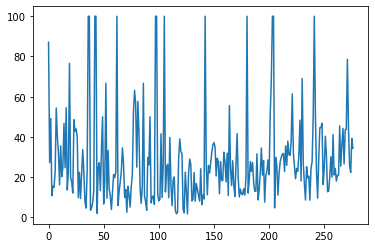

In [21]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(277),acc_grad_data)

### 加速变化率处理

$\frac{油门开度*2}{时间}$

In [59]:
acc_grad_data = []
zero_index = 0
not_zero_list = []
time = 0
count = 0
for i in acc_raw_data:
    time = time + 0.02
    if i <=0.1:
        if index ==0:
            acc_grad_data.append(max(not_zero_list)*2/(time))
            # print("非零数组里有："+str(len(not_zero_list))+"个元素，最大值是"+str(max(not_zero_list)))
            # count = count + 1
        # 检验
        # if count == 5:
        #    break
        not_zero_list = []
        index = 1
        time = 0
        continue
    not_zero_list.append(i)
    index = 0

In [55]:
pd.DataFrame(acc_grad_data).to_csv("E://加速变化率.CSV")

In [56]:
len(acc_grad_data),max(acc_grad_data)

(556, 23.951361575703785)

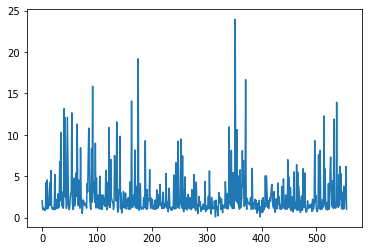

In [57]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(len(acc_grad_data)),acc_grad_data)

未滤波的图像

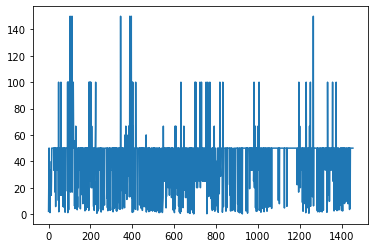

In [60]:
plt.plot(np.arange(len(acc_grad_data)),acc_grad_data)

### 原始加速变化率

In [3]:
acc_data = driving_data["Throttle"]

In [6]:
index = 0
acc_grad_data = []
for i in acc_data:
    if index == 0:
        acc_grad_data.append(0)
        index +=1
        continue
    acc_grad_data.append((i-acc_data[index-1])/0.02)
    index +=1

In [7]:
acc_grad_data

[0,
 -100.0,
 0.0,
 0.0,
 -50.0,
 50.0,
 0.0,
 0.0,
 -50.0,
 100.0,
 0.0,
 0.0,
 0.0,
 -50.0,
 0.0,
 0.0,
 0.0,
 0.0,
 50.0,
 0.0,
 -100.0,
 50.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 100.0,
 -50.0,
 0.0,
 -50.0,
 -200.0,
 250.0,
 -50.0,
 0.0,
 -50.0,
 50.0,
 0.0,
 0.0,
 100.0,
 -50.0,
 0.0,
 0.0,
 -50.0,
 0.0,
 50.0,
 -50.0,
 0.0,
 0.0,
 0.0,
 50.0,
 -100.0,
 100.0,
 0.0,
 -50.0,
 -50.0,
 50.0,
 -50.0,
 50.0,
 50.0,
 0.0,
 -50.0,
 0.0,
 -50.0,
 50.0,
 -50.0,
 100.0,
 -50.0,
 -50.0,
 50.0,
 0.0,
 -100.0,
 0.0,
 0.0,
 50.0,
 -100.0,
 -50.0,
 50.0,
 -50.0,
 -50.0,
 50.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -50.0,
 0.0,
 50.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -50.0,
 0.0,
 50.0,
 -50.0,
 50.0,
 -100.0,
 100.0,
 50.0,
 -100.0,
 0.0,
 50.0,
 -200.0,
 250.0,
 -50.0,
 0.0,
 0.0,
 -50.0,
 0.0,
 50.0,
 -50.0,
 50.0,
 0.0,
 -50.0,
 50.0,
 -50.0,
 50.0,
 0.0,
 -50.0,
 0.0,
 0.0,
 0.0,
 50.0,
 -100.0,
 100.0,
 50.0,
 -100.0,
 -50.0,
 100.0,
 -50.0,
 50.0,
 -50.0,
 0.0,
 0.0,
 50.0,
 -50.0,
 0.0,
 0.0,
 0.0,
 0.0,
 50.0,
 

In [9]:
max(acc_grad_data),len(acc_grad_data)

(400.0, 325562)

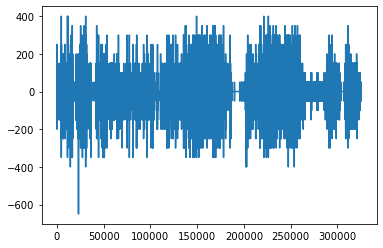

In [11]:
from matplotlib import pyplot as plt
plt.plot(range(325562),acc_grad_data)

In [12]:
pd.DataFrame(acc_grad_data).to_csv("E://原始加速变化率.CSV")

### 原始角速度变化率

In [2]:
acc_data = driving_data["Steering"]

In [3]:
index = 0
acc_grad_data = []
for i in acc_data:
    if index == 0:
        acc_grad_data.append(0)
        index +=1
        continue
    acc_grad_data.append((i-acc_data[index-1])/0.02)
    index +=1

In [7]:
acc_grad_data

[0,
 -100.0,
 0.0,
 0.0,
 -50.0,
 50.0,
 0.0,
 0.0,
 -50.0,
 100.0,
 0.0,
 0.0,
 0.0,
 -50.0,
 0.0,
 0.0,
 0.0,
 0.0,
 50.0,
 0.0,
 -100.0,
 50.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 100.0,
 -50.0,
 0.0,
 -50.0,
 -200.0,
 250.0,
 -50.0,
 0.0,
 -50.0,
 50.0,
 0.0,
 0.0,
 100.0,
 -50.0,
 0.0,
 0.0,
 -50.0,
 0.0,
 50.0,
 -50.0,
 0.0,
 0.0,
 0.0,
 50.0,
 -100.0,
 100.0,
 0.0,
 -50.0,
 -50.0,
 50.0,
 -50.0,
 50.0,
 50.0,
 0.0,
 -50.0,
 0.0,
 -50.0,
 50.0,
 -50.0,
 100.0,
 -50.0,
 -50.0,
 50.0,
 0.0,
 -100.0,
 0.0,
 0.0,
 50.0,
 -100.0,
 -50.0,
 50.0,
 -50.0,
 -50.0,
 50.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -50.0,
 0.0,
 50.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -50.0,
 0.0,
 50.0,
 -50.0,
 50.0,
 -100.0,
 100.0,
 50.0,
 -100.0,
 0.0,
 50.0,
 -200.0,
 250.0,
 -50.0,
 0.0,
 0.0,
 -50.0,
 0.0,
 50.0,
 -50.0,
 50.0,
 0.0,
 -50.0,
 50.0,
 -50.0,
 50.0,
 0.0,
 -50.0,
 0.0,
 0.0,
 0.0,
 50.0,
 -100.0,
 100.0,
 50.0,
 -100.0,
 -50.0,
 100.0,
 -50.0,
 50.0,
 -50.0,
 0.0,
 0.0,
 50.0,
 -50.0,
 0.0,
 0.0,
 0.0,
 0.0,
 50.0,
 

In [4]:
max(acc_grad_data),len(acc_grad_data)

(850.0, 325562)

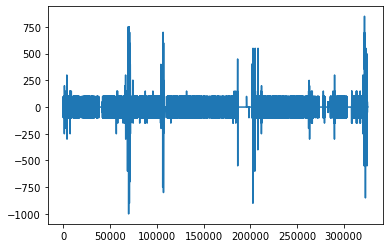

In [5]:
from matplotlib import pyplot as plt
plt.plot(range(325562),acc_grad_data)

In [6]:
pd.DataFrame(acc_grad_data).to_csv("E://原始角速度变化率.CSV")

### 原始制动变化率

In [4]:
acc_data = driving_data["Break"]

In [5]:
index = 0
acc_grad_data = []
for i in acc_data:
    if index == 0:
        acc_grad_data.append(0)
        index +=1
        continue
    acc_grad_data.append((i-acc_data[index-1])/0.02)
    index +=1

In [6]:
acc_grad_data

[0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,


In [7]:
max(acc_grad_data),len(acc_grad_data)

(500.0, 325562)

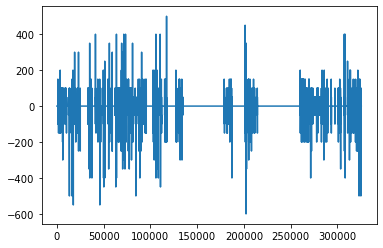

In [8]:
from matplotlib import pyplot as plt
plt.plot(range(325562),acc_grad_data)

In [9]:
pd.DataFrame(acc_grad_data).to_csv("E://原始制动变化率.CSV")

# FCM聚类分析

In [1]:
acc_data = read.csv2("E://加速.CSV",sep = ",")

In [2]:
acc_grad_data = read.csv2("E://加速变化率.CSV",sep = ",")

In [17]:
stop_data = read.csv2("E://制动.CSV",sep = ",")

In [18]:
stop_grad_data = read.csv2("E://制动变化率.CSV",sep = ",")

In [2]:
acc_data$X0[1:10]

[1] 13  1  1  1  1  2  5 10  1  1

In [35]:
acc_grad_data$X0[1:10]

[1] 0.5191693290734898  5.0                 12.5               
 [4] 12.5                4.166666666666666   10.0               
 [7] 0.3955696202531675  0.28058361391695186 6.25               
[10] 8.333333333333334  
310 Levels: 0.030912316542125413 0.03197709830673735 ... 9.375

In [34]:
class(acc_grad_data$X0[1:100])
class(acc_data$X0[1:10])

[1] "factor"

[1] "integer"

这里必须把这个转化为向量形式

In [46]:
as.numeric(as.vector(acc_grad_data$X0))

[1]  0.519  5.000 12.500 12.500  4.167 10.000  0.396  0.281  6.250  8.333
  [11]  6.250  6.250  8.333  3.571  6.250 12.500 12.500 12.500 12.500 12.500
  [21] 12.500 12.500 12.500 12.500 12.500  8.333 12.500 12.500  8.333 12.500
  [31] 12.500  4.167 12.500 12.500  1.420 12.500  8.333 12.500 12.500 12.500
  [41] 12.500 12.500  8.333 12.500 12.500 12.500 12.500  2.564 25.000  0.431
  [51]  1.765  6.250 12.500 12.500  6.250 12.500 12.500 12.500  3.571 25.000
  [61]  6.250 12.500 12.500 12.500  3.571 12.500 12.500  7.143  1.442  7.143
  [71] 12.500  1.538 12.500 12.500  7.143  1.238 12.500  1.950 12.500  0.352
  [81] 12.500 12.500 12.500 12.500 12.500 12.500 12.500 12.500 12.500 12.500
  [91]  4.348 25.000  0.274 25.000 12.500 12.500  0.817 25.000 12.500 25.000
 [101] 12.500  7.143 10.000 37.500 12.500  4.167  5.000 25.000 10.000 12.500
 [111]  8.333 25.000 37.500  4.167 12.500 12.500 16.667 12.500 25.000 16.667
 [121] 12.500 12.500 12.500 12.500  1.531 13.889  1.051 12.500  1.250  4.167
 [131] 16.667  8.333 12.500  2.989 12.500 12.500  2.949  0.818  3.333  1.282
 [141] 12.500 12.500  5.000 12.500 12.500 12.500  8.333 12.500 12.500 12.500
 [151] 12.500 12.500  1.000 12.500 12.500 12.500  4.518 12.500 12.500  3.682
 [161] 12.500 12.500  5.114 12.500  1.974 12.500 12.500 12.500 12.500 12.500
 [171] 12.500 12.500 12.500 12.500  0.611 12.500  6.667  1.271 12.500  0.831
 [181] 12.500 12.500  5.189 12.500 12.500 12.500  1.339 12.500 12.500  1.306
 [191] 12.500 12.500  0.691 25.000 12.500 25.000  6.250 12.500 16.667 12.500
 [201] 25.000  8.333 25.000 12.500  5.000 12.500 16.667 12.500  5.000  8.333
 [211] 12.500 12.500 12.500 12.500  6.667  1.429 12.500  2.899  0.697 12.500
 [221] 12.500 12.500 12.500 12.500 16.667 25.000  2.679  1.786  3.030  3.125
 [231]  6.250  0.155 12.500 12.500  0.681  1.071  0.585  8.333 12.500 12.500
 [241] 12.500  8.333 12.500 12.500 12.500 12.500 12.500 12.500  0.933 12.500
 [251] 12.500  0.388 12.500 12.500 12.500 12.500 12.500 12.500 12.500  1.231
 [261]  0.802  5.000 12.500  7.143 10.000  2.778  3.873  1.705 12.500 12.500
 [271] 12.500 12.500 12.500 12.500 12.500 12.500 12.500 12.500  3.012  4.639
 [281] 12.500  1.216 12.500  0.632 10.000 10.714 10.000  3.431 12.500  1.683
 [291] 12.500 12.500 12.500  0.733 12.500  1.498  0.765  8.333  8.333 12.500
 [301] 12.500 12.500 12.500 12.500 12.500 12.500  0.734 12.500  0.429 12.500
 [311]  1.619 12.500 12.500  5.357  1.064 12.500  1.225 12.500 12.500  3.571
 [321] 12.500  2.799  7.258 12.500  0.600 12.500  0.922  0.590 12.500 12.500
 [331] 12.500 12.500 12.500 12.500 12.500 12.500  2.196 12.500  0.950 12.500
 [341] 12.500 12.500 12.500  0.938 37.500 12.500  4.464 12.500 12.500 12.500
 [351] 12.500 12.500 12.500  1.009 12.500  2.917 12.500 12.500 12.500 12.500
 [361] 12.500 12.500  1.471  1.198 12.500 15.000 10.000  7.500  3.947 16.667
 [371]  4.412 10.714  7.500  5.000  2.778  4.412  6.250  9.375  7.143  8.333
 [381] 15.000 12.500  8.333 16.667 12.500 16.667  3.261 10.000 37.500  4.167
 [391]  4.412 15.000  3.333 10.000 15.000 37.500  6.250  3.125  7.143 25.000
 [401]  0.319 12.500 25.000  5.000 16.667  0.436 12.500 12.500 12.500 12.500
 [411] 12.500 12.500 12.500 12.500  0.891  0.909 25.000 12.500 12.500 12.500
 [421] 12.500 12.500 12.500 12.500  0.837  0.767  0.776 12.500 12.500 12.500
 [431] 12.500 12.500 12.500 12.500 12.500  1.724 12.500  5.500 12.500 12.500
 [441] 12.500  1.136  2.679 12.500 12.500  1.316 12.500 12.121  0.696 12.500
 [451] 12.500  6.250 12.500 12.500 12.500 12.500  1.389 12.500 12.500 12.500
 [461] 12.500 12.500 12.500 12.500  1.424  7.143 15.000  0.387 12.500  0.763
 [471]  8.333  2.419 12.500 12.500  8.333  6.481 12.500 12.500 12.500  0.462
 [481] 12.500  0.969 12.500 12.500  0.605  1.582  8.333  0.680  1.339  0.824
 [491] 12.500  8.333  0.935 12.500 12.500 12.500  0.592  0.954  0.644 12.500
 [501] 12.500 12.500  0.919 12.500  0.752 12.500 12.500  2.326  0.502 12.500
 [511] 12.500 12.500 12.500 12.500  0.839  0.432  8.333 12.500 12.500 12.500

## 示例

In [5]:
library(ppclust)
library(factoextra)
library(cluster)
library(fclust)

Warning message:
"package 'ppclust' was built under R version 3.6.3"Warning message:
"package 'factoextra' was built under R version 3.6.3"Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.6.3"Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa
Warning message:
"package 'fclust' was built under R version 3.6.3"

In [2]:
data(iris)
x=iris[,-5]
res.fcm <- fcm(x, centers=3)

In [3]:
as.data.frame(res.fcm$u)

,Cluster 1,Cluster 2,Cluster 3
,<dbl>,<dbl>,<dbl>
1,0.0010720343,0.9966236,0.0023043797
2,0.0074979471,0.9758525,0.0166495094
3,0.0064145785,0.9798259,0.0137594999
4,0.0101075228,0.9674274,0.0224650314
5,0.0017679352,0.9944704,0.0037617094
6,0.0206196544,0.9345741,0.0448062334
7,0.0065045178,0.9794917,0.0140038150
8,0.0001412048,0.9995473,0.0003115325
9,0.0219024180,0.9303798,0.0477177955


In [9]:
res.fcm$v

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
Cluster 1,5.888932,2.761069,4.363952,1.3973150
Cluster 2,6.775011,3.052382,5.646782,2.0535467
Cluster 3,5.003966,3.414089,1.482816,0.2535463


In [ ]:
x = sort(driving_data$Throttle[-driving_data$Throttle!=0])
res.fcm <- fcm(x, centers=3)

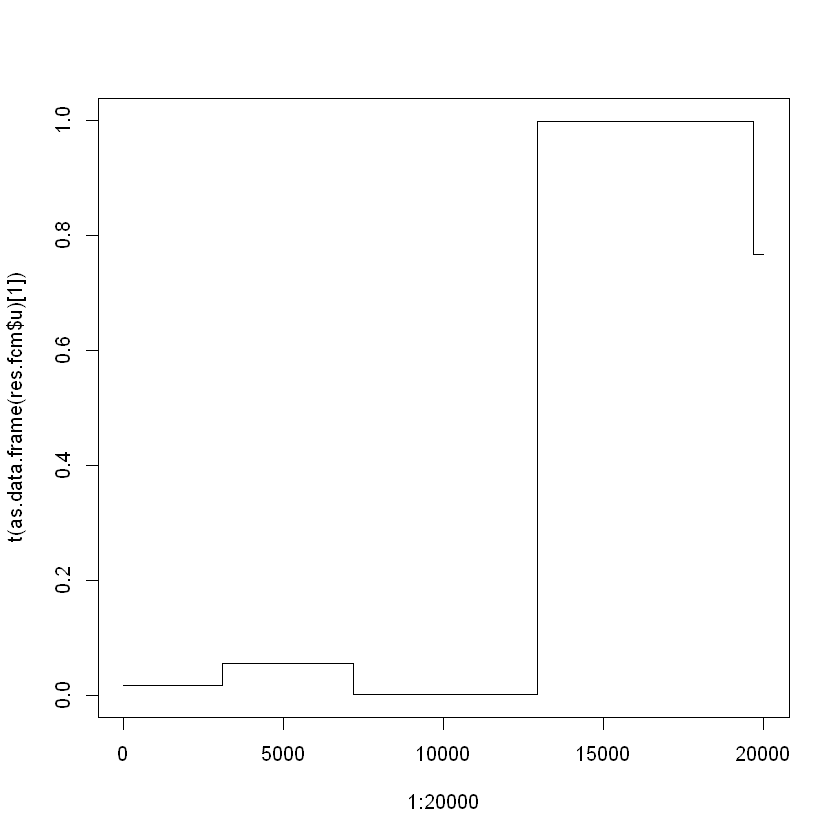

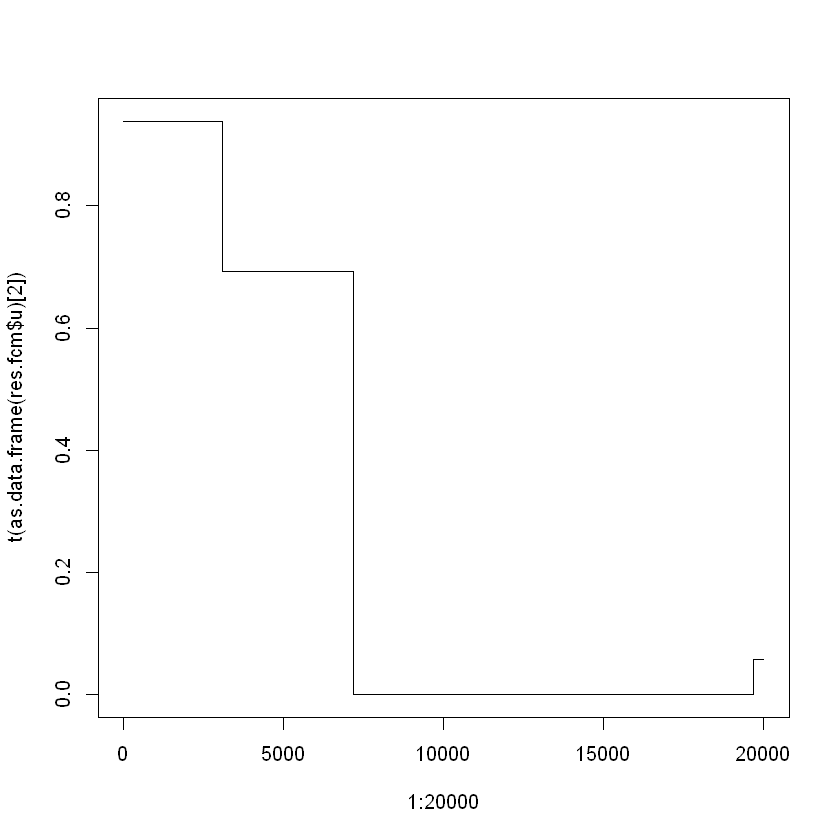

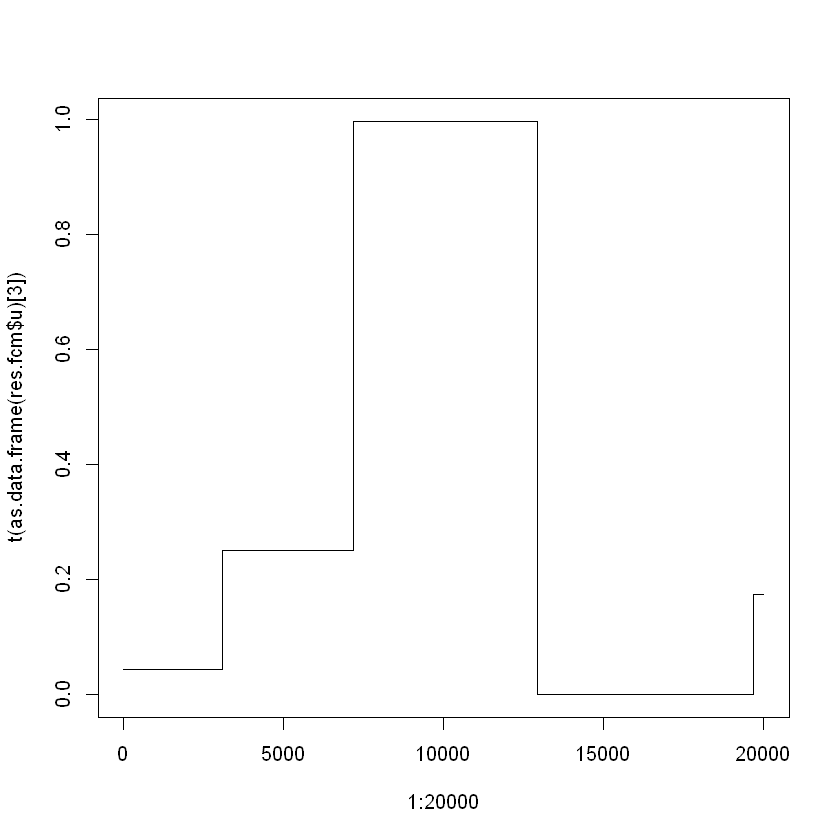

In [68]:
plot(1:20000,t(as.data.frame(res.fcm$u)[1]),type = "l")
plot(1:20000,t(as.data.frame(res.fcm$u)[2]),type = "l")
plot(1:20000,t(as.data.frame(res.fcm$u)[3]),type = "l")

## 加速数据聚类

In [3]:
library(ppclust)
library(factoextra)
library(cluster)
library(fclust)

Warning message:
"package 'ppclust' was built under R version 3.6.3"Warning message:
"package 'factoextra' was built under R version 3.6.3"Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.6.3"Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa
Warning message:
"package 'fclust' was built under R version 3.6.3"

In [10]:
sorted_acc_data = sort(acc_data$X0)
res.fcm <- fcm(sorted_acc_data, centers=3,nstart = 5,m=2)

In [8]:
res.fcm$v

,p-1
Cluster 1,1.341182
Cluster 2,21.701208
Cluster 3,11.928944


In [9]:
as.data.frame(res.fcm$u)

,Cluster 1,Cluster 2,Cluster 3
,<dbl>,<dbl>,<dbl>
1,0.008244959,0.0148026137,0.9769524274
2,0.998755340,0.0002712945,0.0009733654
3,0.998755340,0.0002712945,0.0009733654
4,0.998755340,0.0002712945,0.0009733654
5,0.998755340,0.0002712945,0.0009733654
6,0.994509297,0.0011121248,0.0043785780
7,0.753676665,0.0361718580,0.2101514766
8,0.046087796,0.0252372322,0.9286749715
9,0.998755340,0.0002712945,0.0009733654


In [13]:
as.data.frame(res.fcm$u)

,Cluster 1,Cluster 2,Cluster 3
,<dbl>,<dbl>,<dbl>
1,0.0009733654,0.9987553,0.0002712945
2,0.0009733654,0.9987553,0.0002712945
3,0.0009733654,0.9987553,0.0002712945
4,0.0009733654,0.9987553,0.0002712945
5,0.0009733654,0.9987553,0.0002712945
6,0.0009733654,0.9987553,0.0002712945
7,0.0009733654,0.9987553,0.0002712945
8,0.0009733654,0.9987553,0.0002712945
9,0.0009733654,0.9987553,0.0002712945


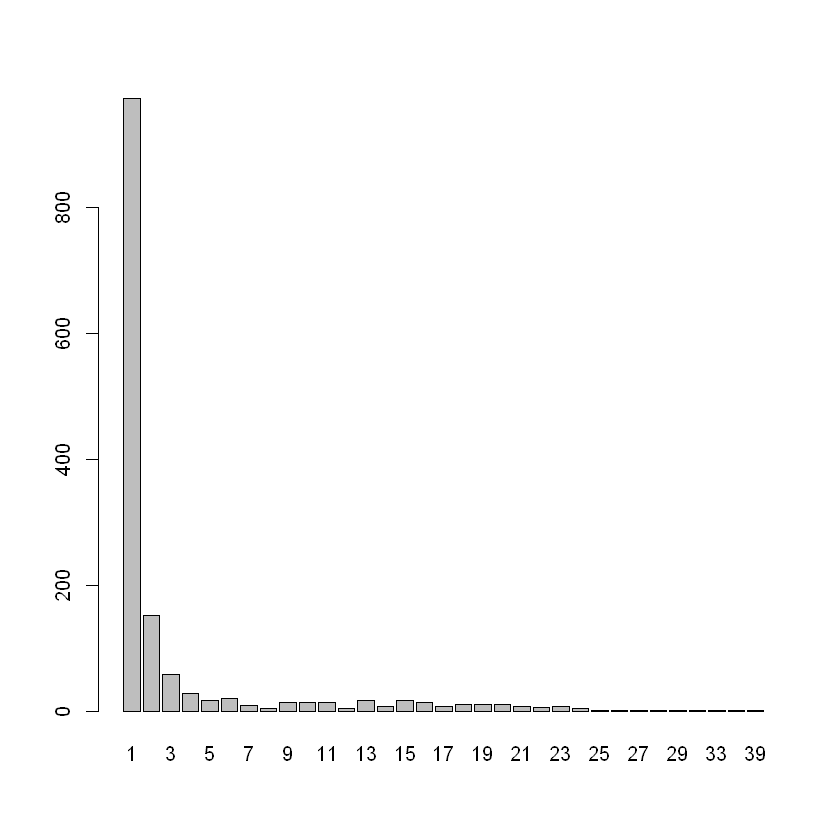

In [14]:
barplot(table(sorted_acc_data))

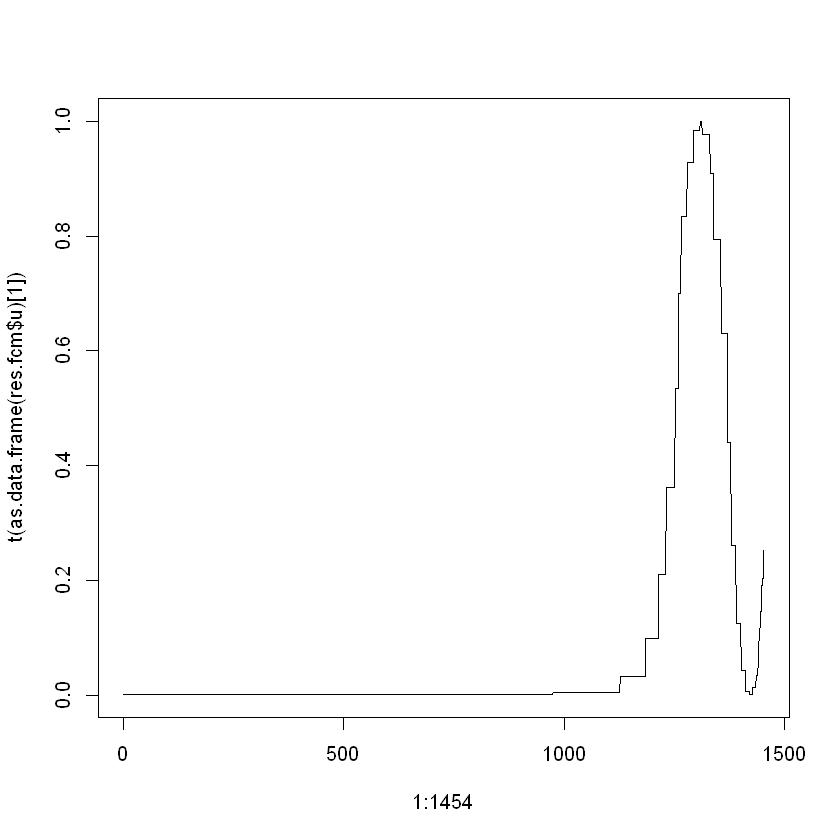

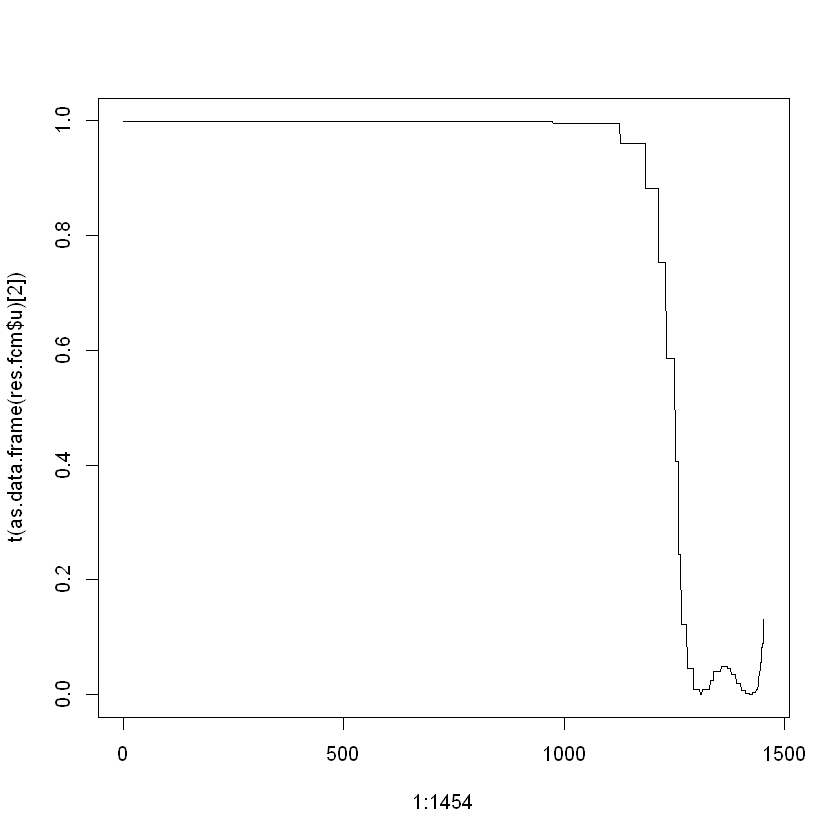

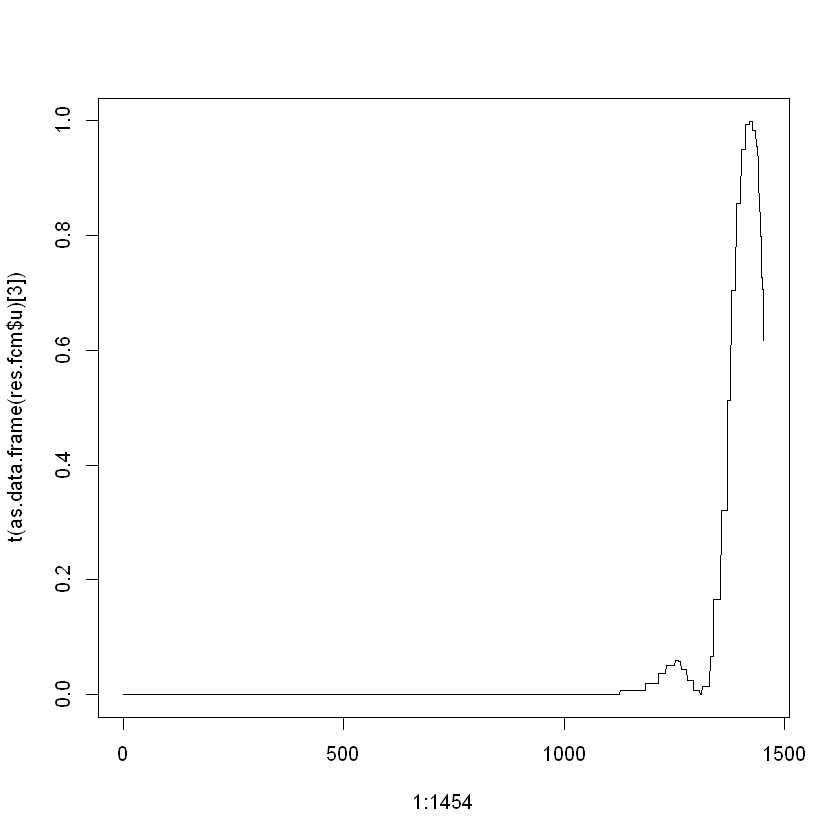

In [11]:
plot(1:1454,t(as.data.frame(res.fcm$u)[1]),type = "l")
plot(1:1454,t(as.data.frame(res.fcm$u)[2]),type = "l")
plot(1:1454,t(as.data.frame(res.fcm$u)[3]),type = "l")

In [80]:
setwd("e://")     # 设置保存路径
png("加速1.png",units="in", width=20, height=5,res=2000)   # 设置分辨率
plot(1:1454,t(as.data.frame(res.fcm$u)[1]),type = "l")
dev.off()

png 
  2

In [83]:
setwd("e://")     # 设置保存路径
png("加速2.png",units="in", width=20, height=5,res=2000)   # 设置分辨率
plot(1:1454,t(as.data.frame(res.fcm$u)[2]),type = "l")
dev.off()

png 
  2

In [82]:
setwd("e://")     # 设置保存路径
png("加速3.png",units="in", width=20, height=5,res=2000)   # 设置分辨率
plot(1:1454,t(as.data.frame(res.fcm$u)[3]),type = "l")
dev.off()

png 
  2

## 加速变化率聚类

In [19]:
library(ppclust)
library(factoextra)
library(cluster)
library(fclust)

In [20]:
sorted_acc_grad_data = sort(as.numeric(as.vector(acc_grad_data$X0)))

In [21]:
res.fcm <- fcm(sorted_acc_grad_data, centers=3)

In [22]:
res.fcm$v

,p-1
Cluster 1,6.674747
Cluster 2,50.948556
Cluster 3,32.731000


In [72]:
as.data.frame(res.fcm$u)

,Cluster 1,Cluster 2,Cluster 3
,<dbl>,<dbl>,<dbl>
1,0.037,0.0083,0.95
2,0.037,0.0083,0.95
3,0.036,0.0081,0.96
4,0.035,0.0078,0.96
5,0.035,0.0077,0.96
6,0.034,0.0076,0.96
7,0.034,0.0076,0.96
8,0.034,0.0075,0.96
9,0.034,0.0075,0.96


In [31]:
as.numeric(as.vector(acc_grad_data$X0))

[1]   2.0766773  20.0000000  50.0000000  50.0000000  16.6666667  40.0000000
   [7]   1.5822785   1.1223345  25.0000000  33.3333333  25.0000000  25.0000000
  [13]  33.3333333  14.2857143  25.0000000  50.0000000  50.0000000  50.0000000
  [19]  50.0000000  50.0000000  50.0000000  50.0000000  50.0000000  50.0000000
  [25]  50.0000000  33.3333333  50.0000000  50.0000000  33.3333333  50.0000000
  [31]  50.0000000  16.6666667  50.0000000  50.0000000   5.6818182  50.0000000
  [37]  33.3333333  50.0000000  50.0000000  50.0000000  50.0000000  50.0000000
  [43]  33.3333333  50.0000000  50.0000000  50.0000000  50.0000000  10.2564103
  [49] 100.0000000   1.7257910   7.0588235  25.0000000  50.0000000  50.0000000
  [55]  25.0000000  50.0000000  50.0000000  50.0000000  14.2857143 100.0000000
  [61]  25.0000000  50.0000000  50.0000000  50.0000000  14.2857143  50.0000000
  [67]  50.0000000  28.5714286   5.7692308  28.5714286  50.0000000   6.1538462
  [73]  50.0000000  50.0000000  28.5714286   4.9504950  50.0000000   7.8014184
  [79]  50.0000000   1.4064698  50.0000000  50.0000000  50.0000000  50.0000000
  [85]  50.0000000  50.0000000  50.0000000  50.0000000  50.0000000  50.0000000
  [91]  17.3913043 100.0000000   1.0976314 100.0000000  50.0000000  50.0000000
  [97]   3.2679739 100.0000000  50.0000000 100.0000000  50.0000000  28.5714286
 [103]  40.0000000 150.0000000  50.0000000  16.6666667  20.0000000 100.0000000
 [109]  40.0000000  50.0000000  33.3333333 100.0000000 150.0000000  16.6666667
 [115]  50.0000000  50.0000000  66.6666667  50.0000000 100.0000000  66.6666667
 [121]  50.0000000  50.0000000  50.0000000  50.0000000   6.1224490  55.5555556
 [127]   4.2056075  50.0000000   5.0000000  16.6666667  66.6666667  33.3333333
 [133]  50.0000000  11.9565217  50.0000000  50.0000000  11.7977528   3.2710280
 [139]  13.3333333   5.1282051  50.0000000  50.0000000  20.0000000  50.0000000
 [145]  50.0000000  50.0000000  33.3333333  50.0000000  50.0000000  50.0000000
 [151]  50.0000000  50.0000000   4.0000000  50.0000000  50.0000000  50.0000000
 [157]  18.0722892  50.0000000  50.0000000  14.7286822  50.0000000  50.0000000
 [163]  20.4545455  50.0000000   7.8947368  50.0000000  50.0000000  50.0000000
 [169]  50.0000000  50.0000000  50.0000000  50.0000000  50.0000000  50.0000000
 [175]   2.4436090  50.0000000  26.6666667   5.0847458  50.0000000   3.3222591
 [181]  50.0000000  50.0000000  20.7547170  50.0000000  50.0000000  50.0000000
 [187]   5.3571429  50.0000000  50.0000000   5.2252252  50.0000000  50.0000000
 [193]   2.7635619 100.0000000  50.0000000 100.0000000  25.0000000  50.0000000
 [199]  66.6666667  50.0000000 100.0000000  33.3333333 100.0000000  50.0000000
 [205]  20.0000000  50.0000000  66.6666667  50.0000000  20.0000000  33.3333333
 [211]  50.0000000  50.0000000  50.0000000  50.0000000  26.6666667   5.7142857
 [217]  50.0000000  11.5942029   2.7863777  50.0000000  50.0000000  50.0000000
 [223]  50.0000000  50.0000000  66.6666667 100.0000000  10.7142857   7.1428571
 [229]  12.1212121  12.5000000  25.0000000   0.6188119  50.0000000  50.0000000
 [235]   2.7257240   4.2857143   2.3397762  33.3333333  50.0000000  50.0000000
 [241]  50.0000000  33.3333333  50.0000000  50.0000000  50.0000000  50.0000000
 [247]  50.0000000  50.0000000   3.7313433  50.0000000  50.0000000   1.5521064
 [253]  50.0000000  50.0000000  50.0000000  50.0000000  50.0000000  50.0000000
 [259]  50.0000000   4.9242424   3.2075472  20.0000000  50.0000000  28.5714286
 [265]  40.0000000  11.1111111  15.4929577   6.8181818  50.0000000  50.0000000
 [271]  50.0000000  50.0000000  50.0000000  50.0000000  50.0000000  50.0000000
 [277]  50.0000000  50.0000000  12.0481928  18.5567010  50.0000000   4.8625793
 [283]  50.0000000   2.5284450  40.0000000  42.8571429  40.0000000  13.7254902
 [289]  50.0000000   6.7307692  50.0000000  50.0000000  50.0000000   2.9333333
 [295]  50.0000000   5.9936909   3.0592734  33.3333333  33.3333333  50.0000000
 [301]  50.0000000  50.0000000  50.0000000  50.000000

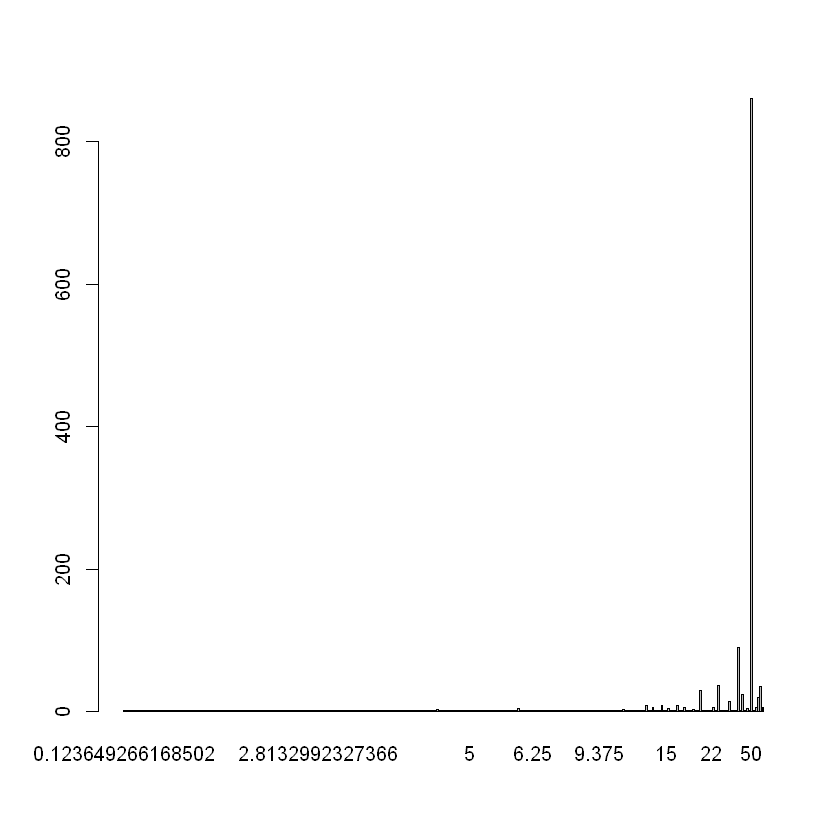

In [28]:
barplot(table(sorted_acc_grad_data))

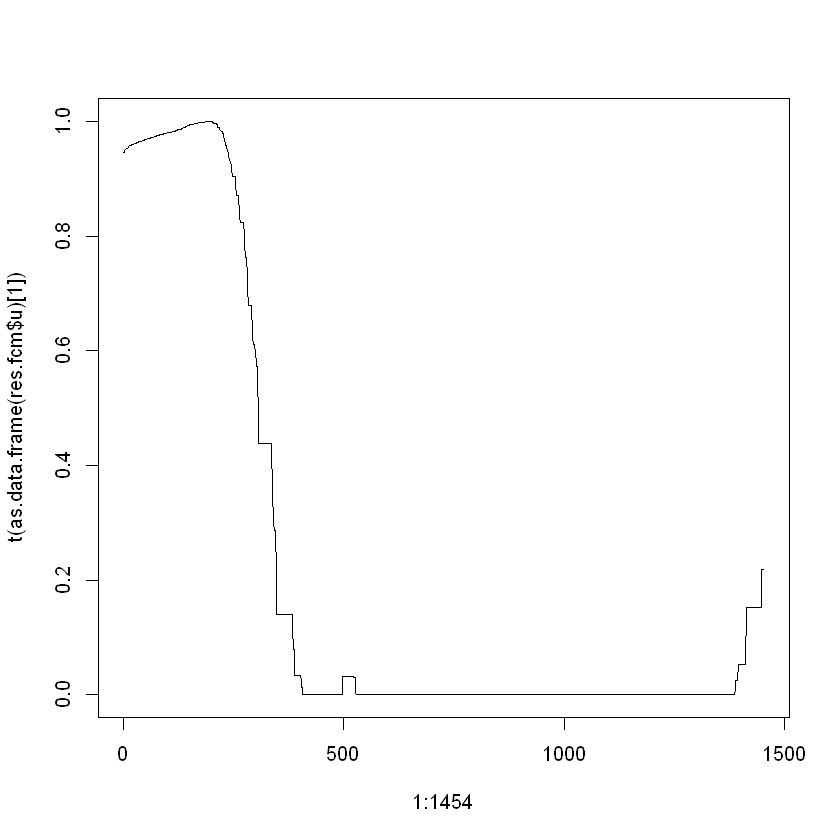

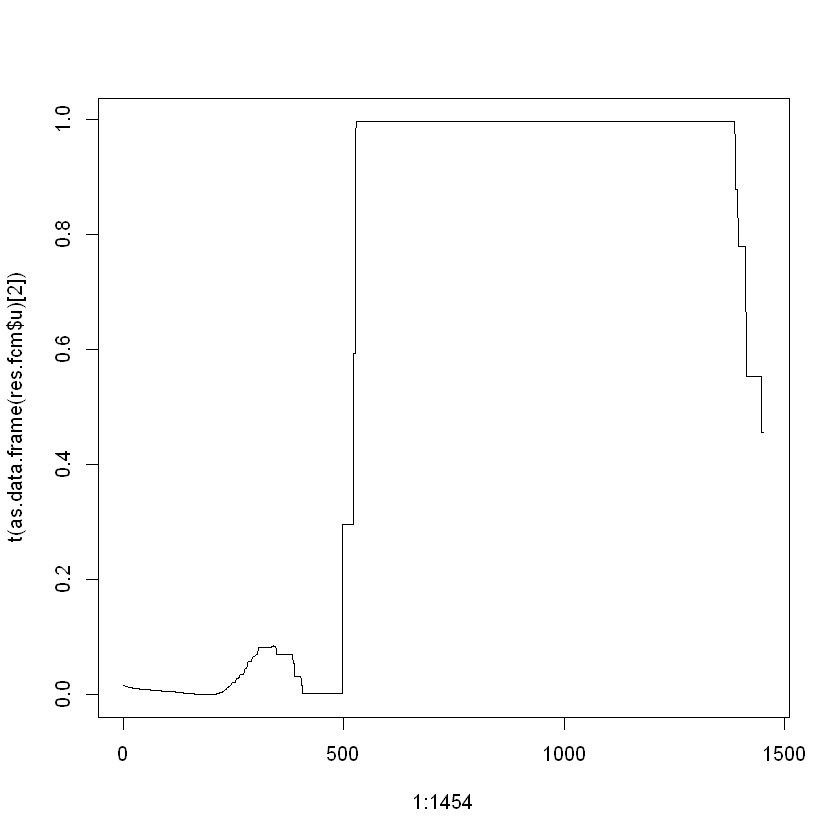

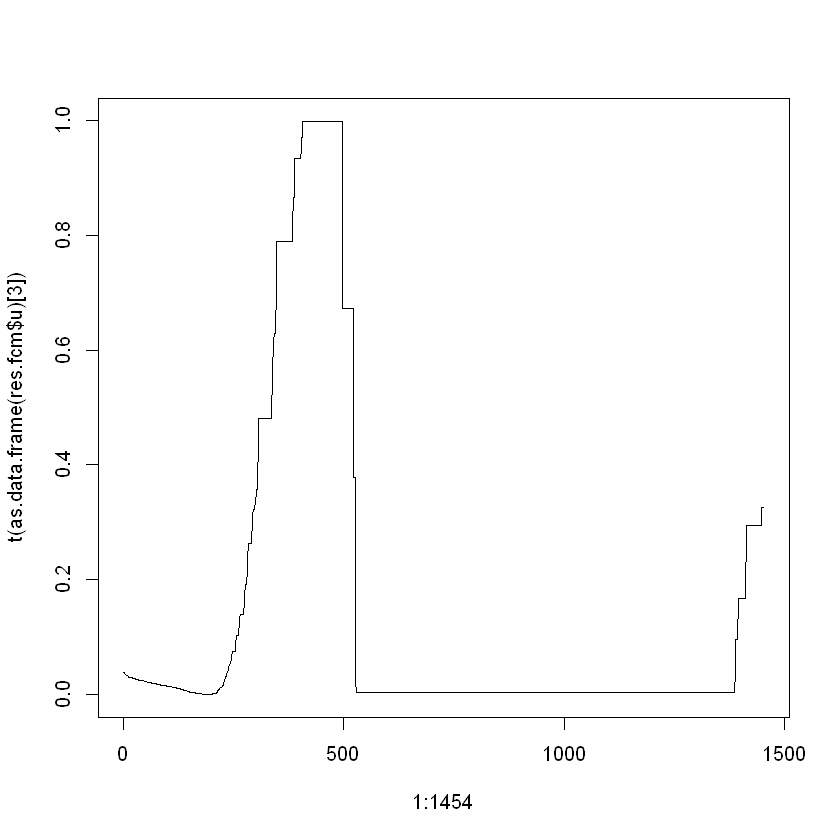

In [27]:
plot(1:1454,t(as.data.frame(res.fcm$u)[1]),type = "l")
plot(1:1454,t(as.data.frame(res.fcm$u)[2]),type = "l")
plot(1:1454,t(as.data.frame(res.fcm$u)[3]),type = "l")

In [74]:
setwd("e://")     # 设置保存路径
png("加速1.png",units="in", width=20, height=5,res=2000)   # 设置分辨率
plot(1:1454,t(as.data.frame(res.fcm$u)[1]),type = "l")
dev.off()

png 
  2

In [75]:
setwd("e://")     # 设置保存路径
png("加速2.png",units="in", width=5, height=5,res=2000)   # 设置分辨率
plot(1:1454,t(as.data.frame(res.fcm$u)[2]),type = "l")
dev.off()

png 
  2

In [76]:
setwd("e://")     # 设置保存路径
png("加速3.png",units="in", width=20, height=5,res=2000)   # 设置分辨率
plot(1:1454,t(as.data.frame(res.fcm$u)[3]),type = "l")
dev.off()

png 
  2

## 制动聚类

In [2]:
library(ppclust)
library(factoextra)
library(cluster)
library(fclust)

Warning message:
"package 'ppclust' was built under R version 3.6.3"Warning message:
"package 'factoextra' was built under R version 3.6.3"Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.6.3"Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa
Warning message:
"package 'fclust' was built under R version 3.6.3"

In [3]:
sorted_stop_data = sort(stop_data$X0)
res.fcm <- fcm(sorted_stop_data, centers=3)

In [6]:
res.fcm$v

,p-1
Cluster 1,39.312980
Cluster 2,3.756218
Cluster 3,73.521566


In [7]:
as.data.frame(res.fcm$u)

,Cluster 1,Cluster 2,Cluster 3
,<dbl>,<dbl>,<dbl>
1,0.005141265,0.9934238,0.001434919
2,0.005141265,0.9934238,0.001434919
3,0.005141265,0.9934238,0.001434919
4,0.005141265,0.9934238,0.001434919
5,0.005141265,0.9934238,0.001434919
6,0.005141265,0.9934238,0.001434919
7,0.005141265,0.9934238,0.001434919
8,0.005141265,0.9934238,0.001434919
9,0.005141265,0.9934238,0.001434919


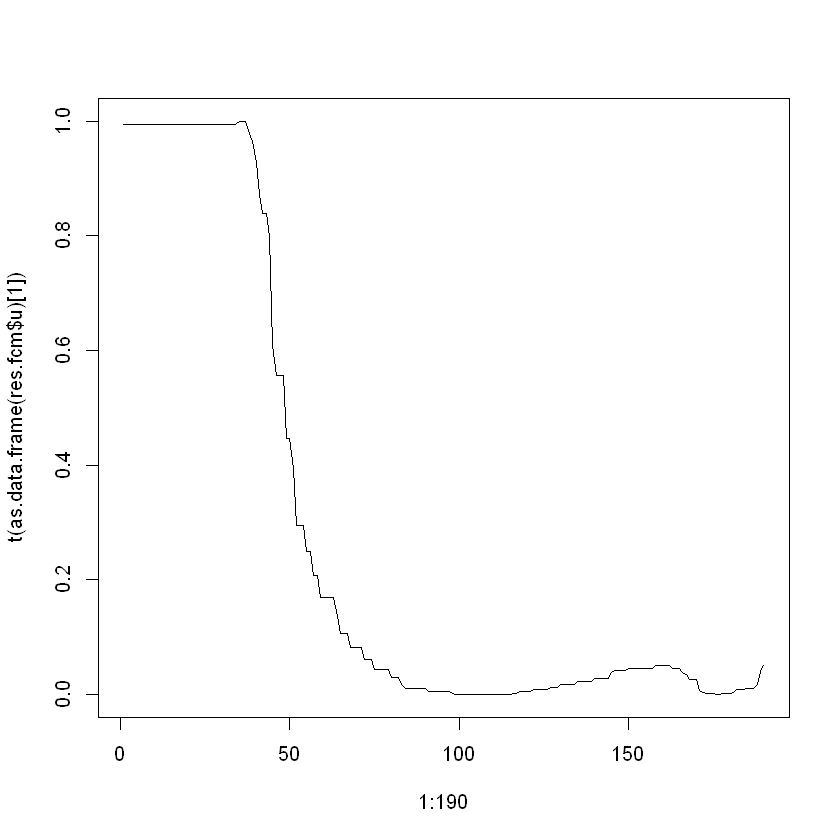

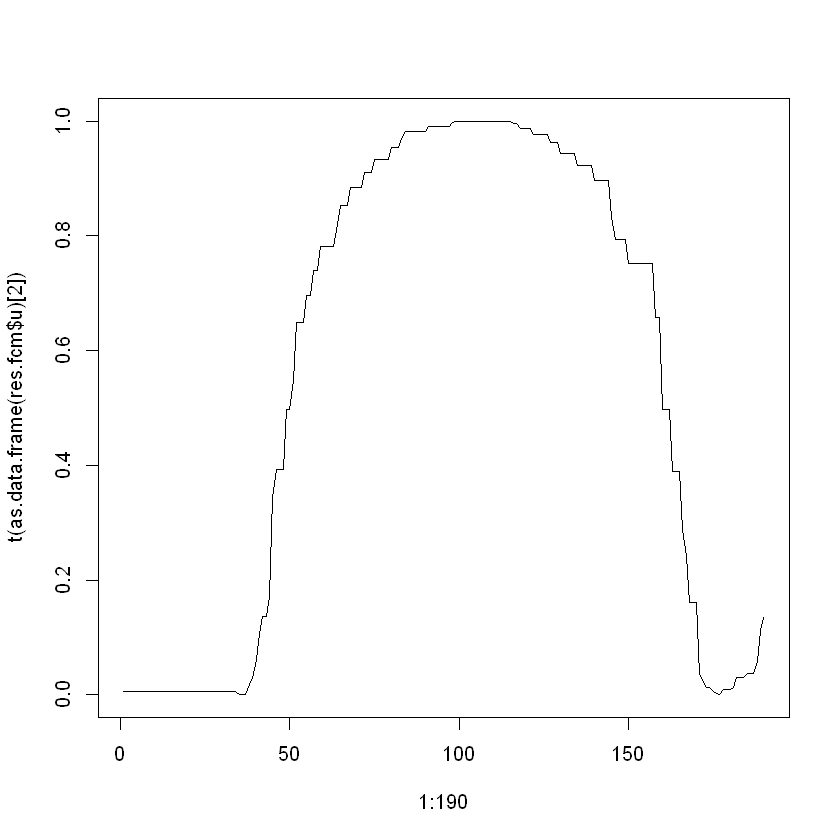

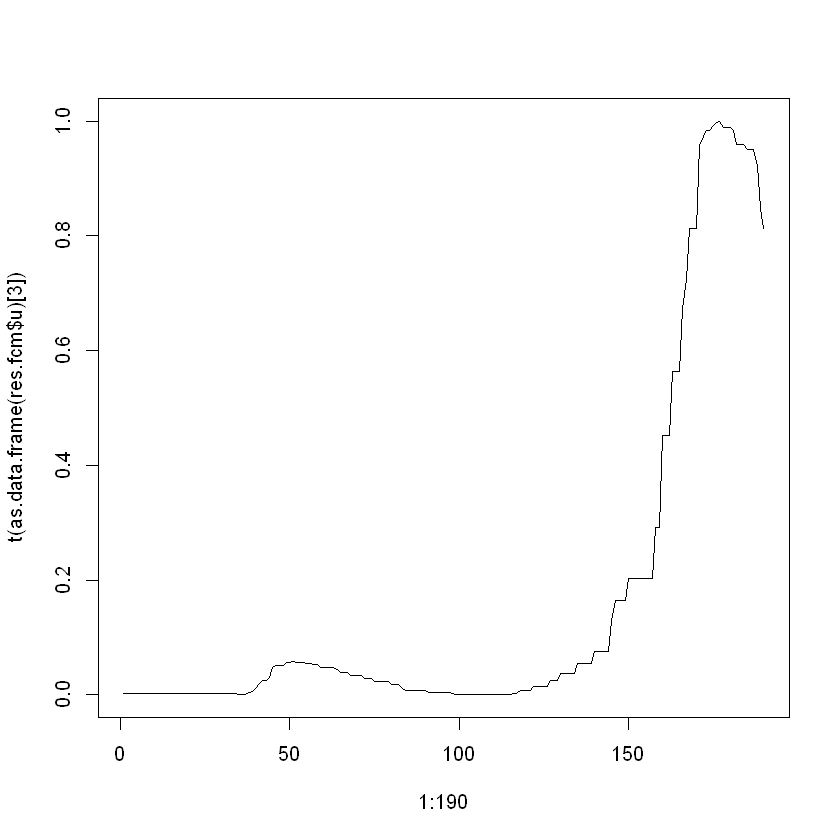

In [4]:
plot(1:190,t(as.data.frame(res.fcm$u)[1]),type = "l")
plot(1:190,t(as.data.frame(res.fcm$u)[2]),type = "l")
plot(1:190,t(as.data.frame(res.fcm$u)[3]),type = "l")

In [80]:
setwd("e://")     # 设置保存路径
png("加速1.png",units="in", width=20, height=5,res=2000)   # 设置分辨率
plot(1:1454,t(as.data.frame(res.fcm$u)[1]),type = "l")
dev.off()

png 
  2

In [83]:
setwd("e://")     # 设置保存路径
png("加速2.png",units="in", width=20, height=5,res=2000)   # 设置分辨率
plot(1:1454,t(as.data.frame(res.fcm$u)[2]),type = "l")
dev.off()

png 
  2

In [82]:
setwd("e://")     # 设置保存路径
png("加速3.png",units="in", width=20, height=5,res=2000)   # 设置分辨率
plot(1:1454,t(as.data.frame(res.fcm$u)[3]),type = "l")
dev.off()

png 
  2

## 驾驶风格聚类数据

In [47]:
import pandas as pd
data = pd.read_excel("E://驾驶意图/data.xlsx")

In [42]:
data[0:5]

,时间,Steering,Break,Throttle,0
0,13:21:54.920,33,0,13,1
1,13:21:54.940,33,0,11,2
2,13:21:54.960,33,0,11,3
3,13:21:54.980,31,0,11,4
4,13:21:55.000,31,0,10,5


计算每60s的均值，并输出到excel表
+ 只要正值组合

In [8]:
from scipy import signal
b, a = signal.butter(8, 0.04, 'lowpass')  

In [49]:
def cal(li):
    data = []
    temp = []
    count = 1
    for i in li:
        temp.append(i)
        if count%50 == 0:
            data.append(max(temp)-min(temp))
            temp = []
        count = count +1
    return data

In [50]:
fengge_data = pd.DataFrame()
fengge_data["Steering"] = cal(signal.filtfilt(b, a, data["Steering"])  )
fengge_data["Throttle"] = cal(signal.filtfilt(b, a, data["Throttle"])  )
fengge_data["Break"] = cal(signal.filtfilt(b, a, data["Break"])  )

In [51]:
fengge_data.to_csv("E://驾驶意图//风格聚类数据.CSV")

## 驾驶风格聚类数据(不滤波)

In [1]:
import pandas as pd
data = pd.read_excel("E://驾驶意图/data.xlsx")

In [2]:
data[0:5]

,Unnamed: 0,时间,Steering,Break,Throttle
0,0,09:45:52.744,-12,0,0
1,1,09:45:52.764,-12,0,0
2,2,09:45:52.784,-12,0,0
3,3,09:45:52.804,-12,0,1
4,4,09:45:52.824,-12,0,0


计算每60s的均值，并输出到excel表
+ 只要正值组合

In [7]:
from scipy import signal
b, a = signal.butter(8, 0.04, 'lowpass')  

In [3]:
def cal(li):
    data = []
    temp = []
    for i in li:
        temp.append(i)
        if count%50 == 0:
            data.append(sum(temp)/50)
            temp = []
        count = count +1
    return data

In [8]:
fengge_data = pd.DataFrame()
fengge_data["Steering"] = signal.filtfilt(b, a, cal(data["Steering"])  )
fengge_data["Throttle"] = signal.filtfilt(b, a, cal(data["Throttle"])  )
fengge_data["Break"] = signal.filtfilt(b, a, cal(data["Break"])  )

In [4]:
fengge_data = pd.DataFrame()
fengge_data["Steering"] = cal(data["Steering"])  
fengge_data["Throttle"] = cal(data["Throttle"])  
fengge_data["Break"] = cal(data["Break"])  

In [9]:
fengge_data.to_csv("C://Users//Administrator//Desktop//农业装备与车辆工程//聚类数据//风格聚类数据.CSV")